Data Analysis Plan
---
Goal: Test multiple models on the relationship between IGT scores & ventral striatal sensitivity between DRD2 carrier groups

- Grab variables of interest
    - P = D.P_payoff
    - Q = D.Q_sensitivity 
    - VS = D.Cards_RNR_VS_mean 
    - AGE = D.AGE
    - SEX = D.female_1
    <br><br>
- Filter to only get subjects who have data for P and VS, and who are white <br><br>
    good=find(~isnan(VS) & ~isnan(P) & D.white(1)<br>
    good_subs = zeros(size(AGE))<br>
    good_subs(good) = 1<br>
    N = length(D.AGE(good))<br>
    <br>
- Separate by DRD2 polymorphism<br><br>
    1 = Del. carrier (low D2) <br>
    0 = Ins/Ins (normal D2) <br>
    drd2_high = find(good_subs & D.DRD2_score==1) <br>
    drd2_low = find(good_subs & D.DRD2_score==0) <br>
    <br>
---

Analysis pipeline:

1. Demographic summary of groups:
    - Age
    - Sex
    - N (number in each group)
<br><br>
2. Group (DRD2 group) differences in:
    - VS
    - P
    - Q
    
         a.) visualize in graph <br>
         b.) analyze with t-test
<br><br>
3. Separate P vs. VS regressions for each group
    - Control for: Age & sex?


Dependencies

In [84]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import ptitprince as pt

from statsmodels.compat import unicode
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.core.display import HTML

#import plotly.plotly as py
#import plotly.express as px

pd.set_option('display.max_columns', 8)

Demographic summary

In [2]:
data = pd.read_csv('DRD2_subset_data.csv', delimiter=',')
data = data.dropna(subset=['P','Q','VS','DRD2', 'AGE', 'female_1'])

# Age

AGE Summary: count    438.000000
mean      42.666667
std        7.370442
min       30.000000
25%       36.000000
50%       43.500000
75%       49.000000
max       54.000000
Name: AGE, dtype: float64


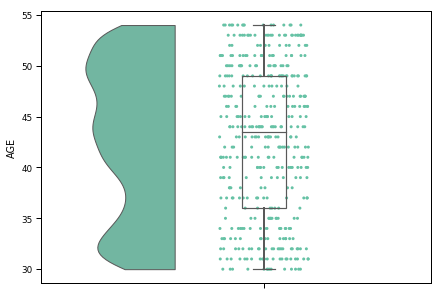

In [95]:
age_summary = data.AGE.describe()
print('AGE Summary:', age_summary)
#AGE_violin = sb.violinplot(y='AGE', data=data, palette='Blues')
AGE_raincloud = pt.RainCloud(y='AGE', data=data, width_viol=.4, width_box=.1, figsize=(7,5))
??pt.RainCloud

In [90]:
axs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa790273198>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fa7902987f0>], dtype=object)

In [96]:
?pt.RainCloud

# Sex

Sex Summary: count    438.000000
mean       0.520548
std        0.500149
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: female_1, dtype: float64


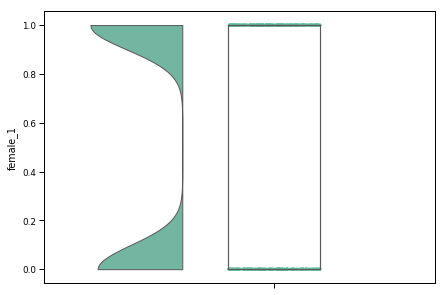

In [92]:
sex_summary = data.female_1.describe()
print('Sex Summary:', sex_summary)
#SEX_violin = sb.violinplot(y='female_1', data=data, palette='Blues')
SEX_raincloud = pt.RainCloud(y='female_1', data=data, width_viol=.4, width_box=.2, figsize=(7,5))

# IGT Scores

IGT Measures Summary 

 P 
 count    438.000000
mean      16.369863
std       29.908177
min      -92.000000
25%       -4.000000
50%       14.000000
75%       40.000000
max       96.000000
Name: P, dtype: float64 

 Q 
 count    438.000000
mean      31.616438
std       25.414800
min      -46.000000
25%       16.000000
50%       38.000000
75%       48.000000
max       86.000000
Name: Q, dtype: float64


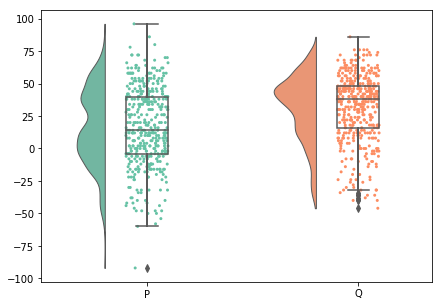

In [5]:
P_summary = data.P.describe()
Q_summary = data.Q.describe()
print('IGT Measures Summary','\n\n','P','\n', P_summary, '\n\n','Q','\n', Q_summary)
#IGT_violin = sb.violinplot(data=data.iloc[:,2:4], palette='Blues')
IGT_raincloud = pt.RainCloud(data=data.iloc[:,2:4], width_viol=.4, width_box=.2, figsize=(7,5))


# VS 

VS Summary 

 count    438.000000
mean       0.107567
std        0.166886
min       -0.543820
25%        0.008345
50%        0.099525
75%        0.204464
max        0.851100
Name: VS, dtype: float64


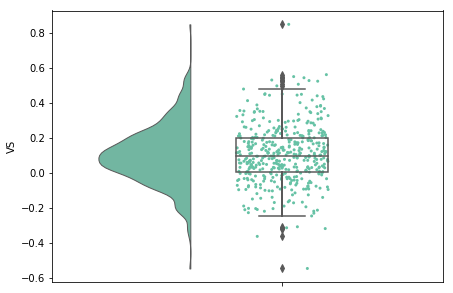

In [6]:
VS_summary = data.VS.describe()
#Ob_summary = data.Obesity.describe()
print('VS Summary', '\n\n', VS_summary)
#print('Obesity Summary', '\n\n', Ob_summary)
#VS_Ob_violin = sb.violinplot(y='VS', data=data, palette='Blues')
VS_raincloud = pt.RainCloud(y='VS', data=data, width_viol=.4, width_box=.2, figsize=(7,5))

# DRD2

DRD2 Carrier Summary: count    438.000000
mean       0.271689
std        0.445339
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: DRD2, dtype: float64


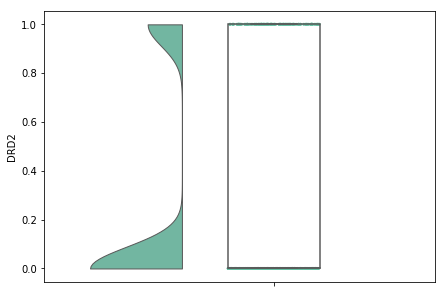

In [7]:
DRD2_summary = data.DRD2.describe()
print('DRD2 Carrier Summary:', DRD2_summary)
#DRD2_violin = sb.violinplot(y='DRD2', data=data, palette='Blues')
DRD2_raincloud = pt.RainCloud(y='DRD2', data=data, width_viol=.4, width_box=.2, figsize=(7,5))

If DRD2 == 1, subjects are DRD2 deletion carriers --> low D2 receptors --> Abnormal

If DRD2 == 0, subjects are DRD2 insertion carriers --> normal D2 receptors --> Control

In [8]:
abnormal = data[data['DRD2'] == 1] #"High DA"
control = data[data['DRD2'] == 0] #"Low DA"

# T-test
Standard Independent 2 sample test that assumes equal population variance

In [102]:
t_test_results = stats.ttest_ind(abnormal.iloc[:,2:5], control.iloc[:,2:5], equal_var=True)
t_test_results

# P, Q, VS

Ttest_indResult(statistic=array([-3.23083657,  0.53904942, -1.77172964]), pvalue=array([ 0.00132777,  0.59012789,  0.07713785]))

Welch's Test which does not assume equal population variance

In [10]:
stats.ttest_ind(abnormal.iloc[:,2:5], control.iloc[:,2:5], equal_var=False)

# P, Q, VS

Ttest_indResult(statistic=array([-3.2966212 ,  0.56431476, -1.7465982 ]), pvalue=array([ 0.00114068,  0.57308456,  0.08219884]))

### Scatter Plot for T-tests

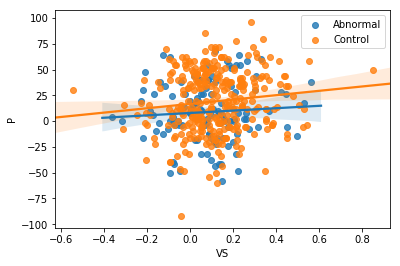

In [11]:
scatter_P_abnormal = sb.regplot(x='VS', y='P', data=abnormal, label='Abnormal').legend()
scatter_P_control = sb.regplot(x='VS', y='P', data=control, label='Control').legend()

In [12]:
#scatter_AGE_abnormal = sb.regplot(x='AGE', y='P', data=abnormal, label='Abnormal').legend()
#scatter_AGE_abnormal = sb.regplot(x='AGE', y='P', data=control, label='Control').legend()

In [13]:
#scatter_Female_abnormal = sb.regplot(x='female_1', y='P', data=abnormal, label='Abnormal').legend()
#scatter_Female_abnormal = sb.regplot(x='female_1', y='P', data=control, label='Control').legend()

# Histograms

### P Score between abnormal and control DRD2 groups

P Score T-test between abnormal and control DRD2 groups


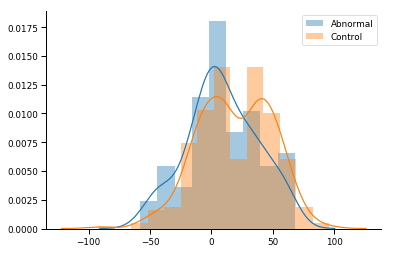

In [14]:
sb.set_context("paper")

abnormal_P_data = pd.concat([abnormal['P']], axis=1)
control_P_data = pd.concat([control['P']], axis=1)


print("P Score T-test between abnormal and control DRD2 groups")
hist_P_abnormal = sb.distplot(abnormal_P_data, label='Abnormal')
hist_P_control = sb.distplot(control_P_data, label='Control')

plt.legend();

sb.despine()

### Q Score T-test between abnormal and control DRD2 groups

Q Score T-test between high and low DA groups


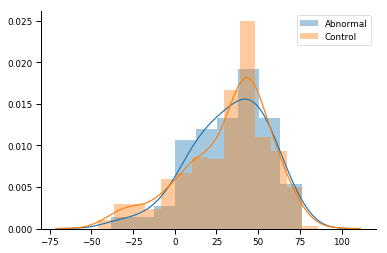

In [15]:
sb.set_context("paper")

abnormal_Q_data = pd.concat([abnormal['Q']], axis=1)
control_Q_data = pd.concat([control['Q']], axis=1)


print("Q Score T-test between high and low DA groups")
hist_Q_abnormal = sb.distplot(abnormal_Q_data, label='Abnormal')
hist_Q_control = sb.distplot(control_Q_data, label='Control')



plt.legend();


sb.despine()

### VS between abnormal and control DRD2 groups

VS T-test between abnormal and control DRD2 groups


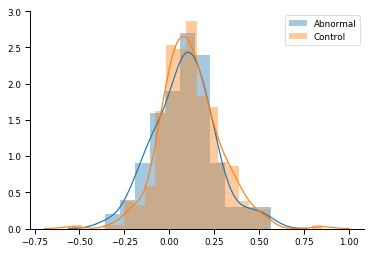

In [16]:
sb.set_context("paper")

abnormal_VS_data = pd.concat([abnormal['VS']], axis=1)
control_VS_data = pd.concat([control['VS']], axis=1)


print("VS T-test between abnormal and control DRD2 groups")
scatter_VS_abnormal = sb.distplot(abnormal_VS_data, label='Abnormal')
scatter_VS_control = sb.distplot(control_VS_data, label='Control')
plt.legend();


sb.despine()

# Linear Regressions

### P vs VS vs DRD2 vs VS*DRD2

with Demographic terms

In [34]:
target = pd.DataFrame(data.P, columns=['P'])
x = pd.DataFrame(data, columns=['DRD2','VS', 'AGE', 'female_1'])
y = target['P']

interaction = PolynomialFeatures(include_bias=False, interaction_only=True)
x_inter = interaction.fit_transform(x)

lm_demographics = linear_model.LinearRegression()
model = lm_demographics.fit(x_inter,y)

lm_demographics_predictions = lm_demographics.predict(x_inter)


print('DRD2','VS', 'Age', 'Female', 'DRD2*VS', 'DRD2*Age', 'DRD2*Female', 'VS*Age', 'VS*Female', 'Age*Female','Intercept')
print(interaction.powers_)
print(lm_demographics.coef_)


DRD2 VS Age Female DRD2*VS DRD2*Age DRD2*Female VS*Age VS*Female Age*Female Intercept
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [0 1 1 0]
 [0 1 0 1]
 [0 0 1 1]]
[ -6.3185817  -46.69113861  -0.21435127  -2.38790095  -5.51097447
  -0.07005187  -0.31524583   1.05261845  38.63706059  -0.25987709]


In [67]:
target = pd.DataFrame(data.P, columns=['P'])
x = pd.DataFrame(data, columns=['DRD2','VS'])
y = target['P']

interaction = PolynomialFeatures(include_bias=False, interaction_only=True)
x_inter = interaction.fit_transform(x)

lm_simple = linear_model.LinearRegression()
model = lm_simple.fit(x_inter,y)

lm_simple_predictions = lm_simple.predict(x_inter)


print('DRD2','VS','DRD2*VS')
print(interaction.powers_)
print(lm_simple.coef_)


DRD2 VS DRD2*VS
[[1 0]
 [0 1]
 [1 1]]
[ -8.79049931  21.14001795  -9.57295359]


In [68]:
columns = ['DRD2','VS', 'Age', 'Female', 'DRD2*VS', 'DRD2*Age', 'DRD2*Female', 'VS*Age', 'VS*Female', 'Age*Female','Intercept']

coef_demographics= lm_demographics.coef_.tolist() + [float(lm_demographics.intercept_)]
pd.DataFrame({'With Demographics':coef_demographics}, columns)

,With Demographics
DRD2,-6.318582
VS,-46.691139
Age,-0.214351
Female,-2.387901
DRD2*VS,-5.510974
DRD2*Age,-0.070052
DRD2*Female,-0.315246
VS*Age,1.052618
VS*Female,38.637061
Age*Female,-0.259877


In [69]:
columns = ['DRD2','VS', 'DRD2*VS','Intercept']

coef_demographics= lm_demographics.coef_.tolist() + [float(lm_demographics.intercept_)]
coef_simple = lm_simple.coef_.tolist() + [float(lm_simple.intercept_)]
pd.DataFrame({'Without': coef_simple}, columns)

,Without
DRD2,-8.790499
VS,21.140018
DRD2*VS,-9.572954
Intercept,16.703925


without Demographic terms

In [97]:
target = pd.DataFrame(data.P, columns=['P'])
x = pd.DataFrame(data, columns=['DRD2','VS'])
y = target['P']
results = smf.ols(formula='P ~ DRD2 + VS + DRD2 * VS',data=data).fit()

HTML(results.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.7039,2.020,8.269,0.000,12.733,20.674
DRD2,-8.7905,3.634,-2.419,0.016,-15.932,-1.649
VS,21.1400,10.020,2.110,0.035,1.447,40.833
DRD2:VS,-9.5730,18.830,-0.508,0.611,-46.582,27.436


In [57]:
columns = ['VS', 'Age', 'Female', 'VS*Age', 'Age*Female', 'Female*VS', 'Intercept']

coef_abnormal_with = lm_demographics.coef_.tolist() + [float(lm_demographics.intercept_)]
coef_abnormal_without = lm_abnormal_simple.coef_.tolist() + ['','', '', '', ''] + [float(lm_abnormal_simple.intercept_)]

pd.DataFrame({'with Controls': coef_abnormal_with, 'without': coef_abnormal_without}, columns)

ValueError: Shape of passed values is (2, 11), indices imply (2, 7)

### Control: P vs VS

with interactions

In [ ]:
target = pd.DataFrame(control.P, columns=['P'])
x = pd.DataFrame(control, columns=['VS', 'AGE', 'female_1'])
y = target['P']

interaction = PolynomialFeatures(include_bias=False, interaction_only=True)
x_inter = interaction.fit_transform(x)

lm_control_int = linear_model.LinearRegression()
model = lm_control_int.fit(x_inter,y)

control_predictions = lm_control_int.predict(x_inter)


#print('Y = AX1 + BX2 + CX3 + DX1*X2 + EX2*X3 + FX3*X1')
#print('\nX1 = VS \nX2 = AGE \nX3 = Female \n')
#print('score:', lm_control_int.score(x_inter,y))
#print(lm_control_int.coef_)
#print('intercept:', lm_control_int.intercept_)

without interactions

In [63]:
target = pd.DataFrame(control.P, columns=['P'])
x = pd.DataFrame(control, columns=['VS'])
y = target['P']

interaction = PolynomialFeatures(include_bias=False, interaction_only=True)
x_inter = interaction.fit_transform(x)

lm_control_simple = linear_model.LinearRegression()
model = lm_control_simple.fit(x_inter,y)

abnormal_predictions = lm_control_simple.predict(x_inter)

#print('Y = AX1 + BX2 + CX3 + DX1*X2 + EX2*X3 + FX3*X1')
#print('\nX1 = VS \nX2 = AGE \nX3 = Female \n')
#print('score:', lm_control_simple.score(x_inter,y))
#print(lm_control_simple.coef_)
#print('intercept:', lm_control_simple.intercept_)

In [64]:
columns = ['VS', 'Age', 'Female', 'VS*Age', 'Age*Female', 'Female*VS', 'Intercept']

coef_control_with = lm_control_int.coef_.tolist() + [float(lm_control_int.intercept_)]
coef_control_without = lm_control_simple.coef_.tolist() + ['','', '', '', ''] + [float(lm_control_simple.intercept_)]

pd.DataFrame({'with Controls': coef_control_with, 'without': coef_control_without}, columns)

NameError: name 'lm_control_int' is not defined

In [65]:
x = pd.DataFrame(control, columns=['VS', 'AGE', 'female_1'])
y = target['P']
results = sm.OLS(y,x).fit()
results.params
print("DRD2==0")
print(results.summary())

DRD2==0
                                 OLS Regression Results                                
Dep. Variable:                      P   R-squared (uncentered):                   0.298
Model:                            OLS   Adj. R-squared (uncentered):              0.291
Method:                 Least Squares   F-statistic:                              44.66
Date:                Thu, 24 Oct 2019   Prob (F-statistic):                    4.35e-24
Time:                        10:02:20   Log-Likelihood:                         -1535.0
No. Observations:                 319   AIC:                                      3076.
Df Residuals:                     316   BIC:                                      3087.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------